In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/sarah/ML/master_thesis/Datasets/shuffled_data.csv")# Load mapping and clinical data
id_map = pd.read_csv("/Users/sarah/ML/master_thesis/Datasets/patient_id_mapping.csv")
id_map.columns = ['Anon.Patient_ID', 'study_id']
clinical = pd.read_excel("/Users/sarah/Library/Mobile Documents/iCloud~md~obsidian/Documents/MSc Medizininformatik/Master Thesis/Data/219 patients.xlsx")

# Merge measurement data with mapping
df_with_id = df.merge(id_map, on="Anon.Patient_ID", how="left")

# Merge with clinical data
df_full = df_with_id.merge(clinical, left_on="study_id", right_on="study_id", how="left")

In [3]:
output_folder = "/Users/sarah/Library/Mobile Documents/iCloud~md~obsidian/Documents/MSc Medizininformatik/Master Thesis/Writing/Plots"


# Sex

Counts by sex:
 sex_str
Male      138
Female     81
Name: count, dtype: int64
Proportion by sex:
 sex_str
Male      0.630137
Female    0.369863
Name: count, dtype: float64


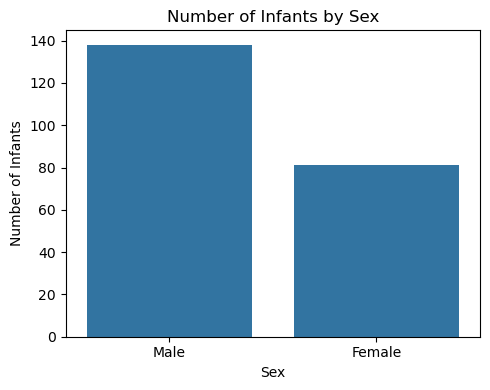

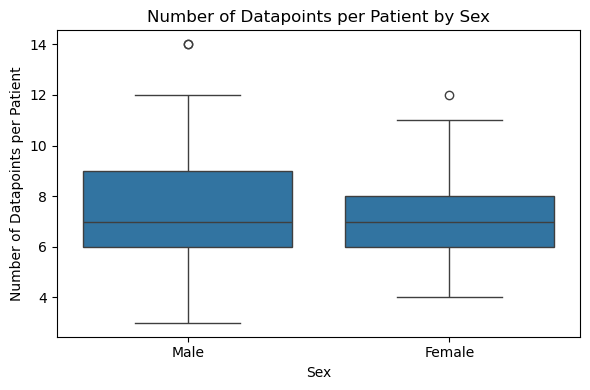

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

# Map sex codes to full labels
sex_dict = {0: "Male", 1: "Female"}

# Replace sex codes with strings for plotting
df_full["sex_str"] = df_full["sex"].map(sex_dict)
patient_counts = df_full.groupby("Anon.Patient_ID").size().reset_index(name="datapoints_per_patient")
sex_map = df_full.drop_duplicates("Anon.Patient_ID")[["Anon.Patient_ID", "sex_str"]]
patient_counts = patient_counts.merge(sex_map, on="Anon.Patient_ID", how="left")

# 1. Count and proportion of each sex
sex_counts = df_full.drop_duplicates("Anon.Patient_ID")["sex_str"].value_counts().reindex(["Male", "Female"])
sex_props = sex_counts / sex_counts.sum()
print("Counts by sex:\n", sex_counts)
print("Proportion by sex:\n", sex_props)

plt.figure(figsize=(5, 4))
sns.barplot(x=sex_counts.index, y=sex_counts.values)
plt.title("Number of Infants by Sex")
plt.ylabel("Number of Infants")
plt.xlabel("Sex")
plt.tight_layout()
plt.show()
# plt.savefig(f"{output_folder}/barplot_number_by_sex.png", dpi=300)

# 2. Number of datapoints per patient, by sex
plt.figure(figsize=(6, 4))
sns.boxplot(x="sex_str", y="datapoints_per_patient", data=patient_counts, order=["Male", "Female"])
plt.title("Number of Datapoints per Patient by Sex")
plt.xlabel("Sex")
plt.ylabel("Number of Datapoints per Patient")
plt.tight_layout()
plt.show()
# plt.savefig(f"{output_folder}/boxplot_datapoints_by_sex.png", dpi=300)




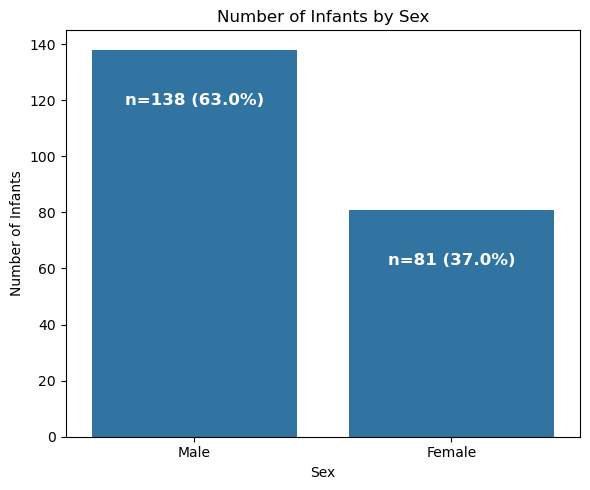

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_counts = df_full.drop_duplicates("Anon.Patient_ID")["sex_str"].value_counts().reindex(["Male", "Female"])
total = sex_counts.sum()
percentages = (sex_counts / total * 100).round(1)

plt.figure(figsize=(6, 5))
sns.barplot(x=sex_counts.index, y=sex_counts.values)

for i, (count, pct) in enumerate(zip(sex_counts.values, percentages.values)):
    # Place label inside bar, slightly below the top
    plt.text(i, count - (0.07 * total), f"n={count} ({pct}%)",
             ha='center', va='top', fontweight='bold', fontsize=12, color='white')

plt.title("Number of Infants by Sex")
plt.ylabel("Number of Infants")
plt.xlabel("Sex")
plt.tight_layout()
plt.show()
# plt.savefig(f"{output_folder}/barplot_number_by_sex.png", dpi=300)


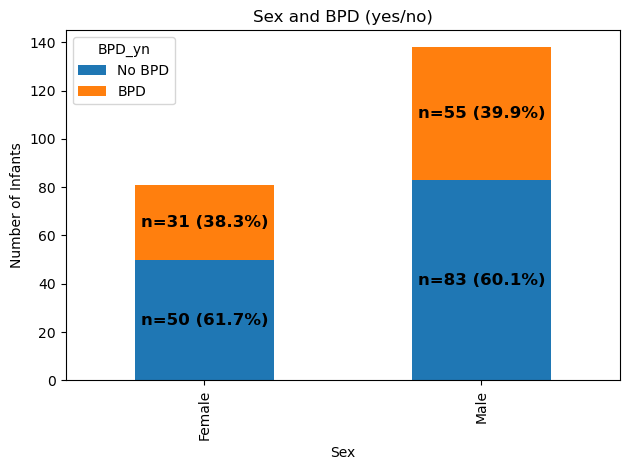

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create crosstab of sex and BPD_yn (unique infants only)
bpdyn_sex_tab = pd.crosstab(df_full.drop_duplicates("Anon.Patient_ID")["sex_str"],
                            df_full.drop_duplicates("Anon.Patient_ID")["BPD_yn"])

ax = bpdyn_sex_tab.plot(kind="bar", stacked=True)
plt.title("Sex and BPD (yes/no)")
plt.xlabel("Sex")
plt.ylabel("Number of Infants")

# Add n and percent for each bar segment
for idx, (sex_label, row) in enumerate(bpdyn_sex_tab.iterrows()):
    total = row.sum()
    cumsum = 0
    for bpd_val, n in enumerate(row):
        pct = (n / total * 100) if total > 0 else 0
        y = cumsum + n / 2
        label = f"n={n} ({pct:.1f}%)"
        plt.text(idx, y, label, ha='center', va='center', fontweight='bold', fontsize=12)
        cumsum += n

plt.legend(["No BPD", "BPD"], title="BPD_yn")
plt.tight_layout()
plt.show()
#plt.savefig(f"{output_folder}/barplot_sex_by_bpdyn.png", dpi=300)



In [7]:
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(bpdyn_sex_tab)
print(f"Chi-squared: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("Significant association between sex and BPD occurrence.")
else:
    print("No significant association between sex and BPD occurrence.")


Chi-squared: 0.01, p-value: 0.9296
No significant association between sex and BPD occurrence.


## BPD Severity

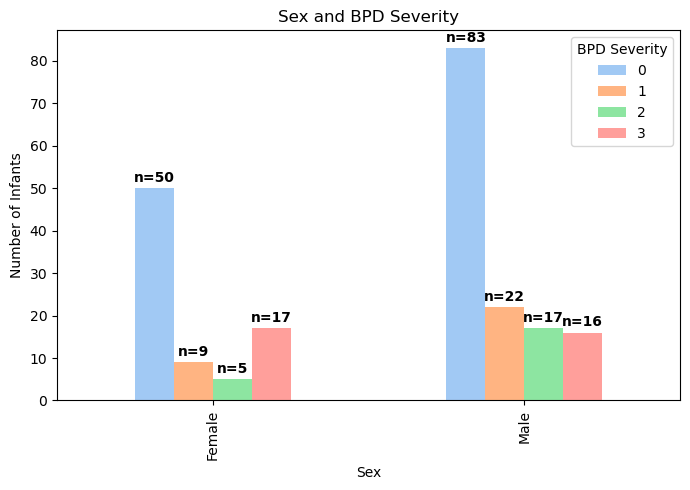

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crosstab of sex and BPD_severity
bpdsev_sex_tab = pd.crosstab(df_full.drop_duplicates("Anon.Patient_ID")["sex_str"],
                             df_full.drop_duplicates("Anon.Patient_ID")["BPD_severity"])

fig, ax = plt.subplots(figsize=(7, 5))
bar_containers = bpdsev_sex_tab.plot(kind="bar", stacked=False, color=sns.color_palette("pastel"), ax=ax)

plt.title("Sex and BPD Severity")
plt.xlabel("Sex")
plt.ylabel("Number of Infants")
plt.legend(title="BPD Severity")

# Loop through each bar container and each bar, and put the label on top of the bar
for bars in bar_containers.containers:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.8, f"n={int(height)}",
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
fig.savefig(f"{output_folder}/barplot_sex_by_bpdsev.png", dpi=300)
plt.show()
# fig.savefig(f"{output_folder}/barplot_sex_by_bpdsev.png", dpi=300)


In [9]:
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(bpdsev_sex_tab)
print(f"Chi-squared: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("Significant association between sex and BPD severity.")
else:
    print("No significant association between sex and BPD severity.")


Chi-squared: 5.77, p-value: 0.1233
No significant association between sex and BPD severity.


## BPD YN & Severity

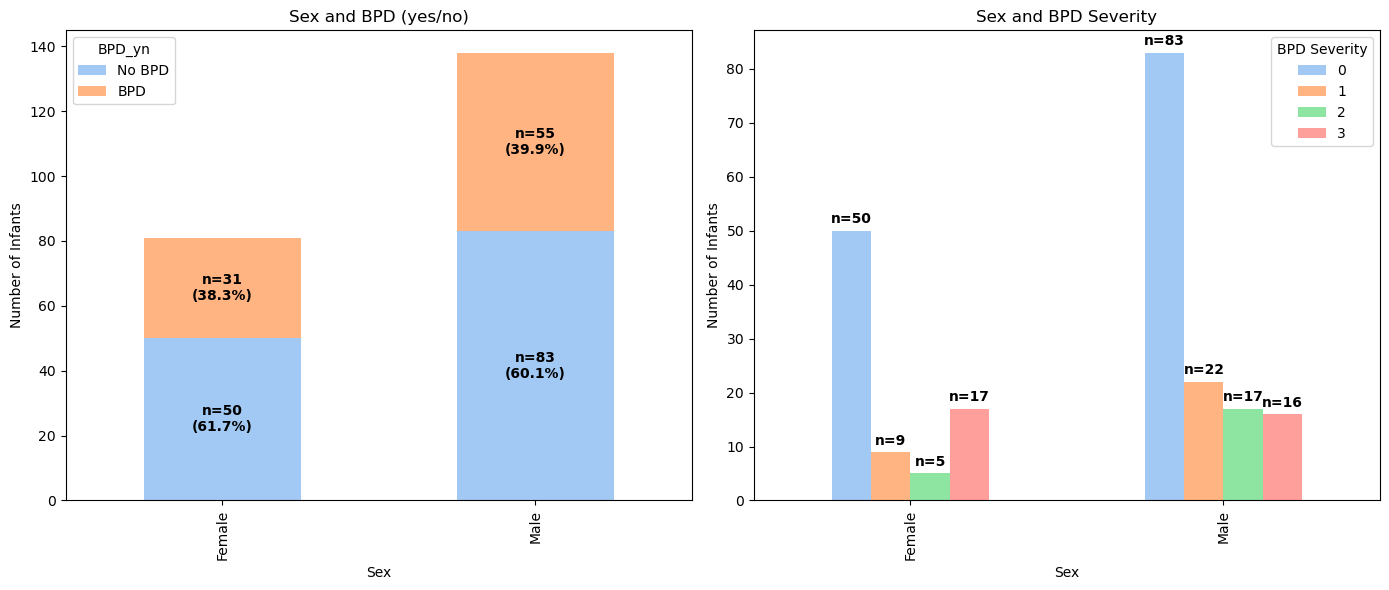

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure unique infants
unique_df = df_full.drop_duplicates("Anon.Patient_ID")

# Create crosstabs
bpdyn_sex_tab = pd.crosstab(unique_df["sex_str"], unique_df["BPD_yn"])
bpdsev_sex_tab = pd.crosstab(unique_df["sex_str"], unique_df["BPD_severity"])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Side-by-side plots

# --- Left plot: Sex and BPD (yes/no) ---
ax1 = axes[0]
bpdyn_sex_tab.plot(kind="bar", stacked=True, color=sns.color_palette("pastel"), ax=ax1)
ax1.set_title("Sex and BPD (yes/no)")
ax1.set_xlabel("Sex")
ax1.set_ylabel("Number of Infants")
ax1.legend(["No BPD", "BPD"], title="BPD_yn")

# Annotate bars with counts and percent
for idx, (sex_label, row) in enumerate(bpdyn_sex_tab.iterrows()):
    total = row.sum()
    cumsum = 0
    for bpd_val, n in enumerate(row):
        pct = (n / total * 100) if total > 0 else 0
        y = cumsum + n / 2
        label = f"n={n}\n({pct:.1f}%)"
        ax1.text(idx, y, label, ha='center', va='center', fontweight='bold', fontsize=10)
        cumsum += n

# --- Right plot: Sex and BPD Severity ---
ax2 = axes[1]
bpdsev_sex_tab.plot(kind="bar", stacked=False, color=sns.color_palette("pastel"), ax=ax2)
ax2.set_title("Sex and BPD Severity")
ax2.set_xlabel("Sex")
ax2.set_ylabel("Number of Infants")
ax2.legend(title="BPD Severity")

# Annotate bars with counts
for bars in ax2.containers:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width() / 2, height + 0.8, f"n={int(height)}",
                     ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(f"{output_folder}/barplot_sex_bpd_combined.png", dpi=300)
plt.show()


## Gestational Age by Sex and BPD_yn

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_32199/308218503.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_full.drop_duplicates("Anon.Patient_ID").groupby(["GA_bin", "sex_str"])


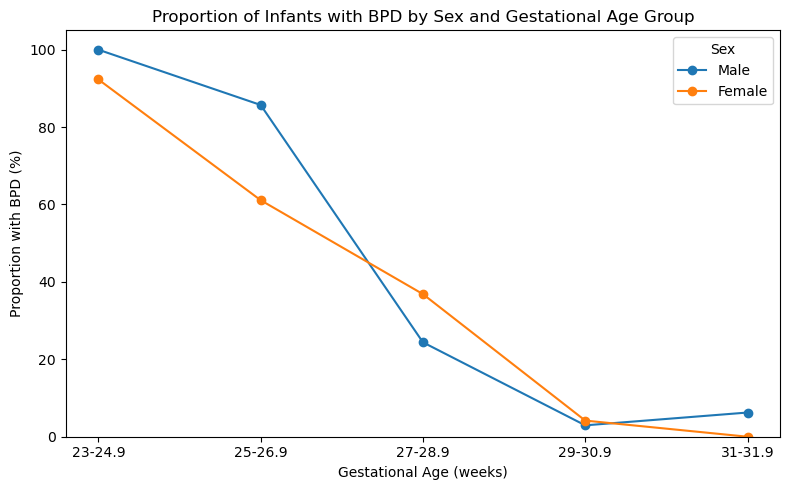

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create gestational age bins (use 2-week bins for clarity)
ga_bins = [23, 25, 27, 29, 31, 32]
ga_labels = ["23-24.9", "25-26.9", "27-28.9", "29-30.9", "31-31.9"]
df_full["GA_bin"] = pd.cut(df_full["GA_wd"], bins=ga_bins, labels=ga_labels, right=False, include_lowest=True)

# 2. Group and calculate proportion of BPD_yn==1 for each sex and GA_bin
grouped = df_full.drop_duplicates("Anon.Patient_ID").groupby(["GA_bin", "sex_str"])
proportion_bpd = grouped["BPD_yn"].mean().unstack() * 100  # Now in percent

# 3. Plot
plt.figure(figsize=(8, 5))
for sex in ["Male", "Female"]:
    plt.plot(ga_labels, proportion_bpd[sex], marker='o', label=sex)

plt.title("Proportion of Infants with BPD by Sex and Gestational Age Group")
plt.xlabel("Gestational Age (weeks)")
plt.ylabel("Proportion with BPD (%)")
plt.legend(title="Sex")
plt.ylim(0, 105)
plt.tight_layout()
plt.savefig(f"{output_folder}/proportion_bpd_by_sex_and_ga_bin.png", dpi=300)
plt.show()
# plt.savefig(f"{output_folder}/proportion_bpd_by_


In [12]:
from scipy.stats import chi2_contingency, fisher_exact

# Group by unique infants
df_unique = df_full.drop_duplicates("Anon.Patient_ID")
ga_bins = [23, 25, 27, 29, 31, 32]
ga_labels = ["23-24.9", "25-26.9", "27-28.9", "29-30.9", "31-31.9"]
df_unique["GA_bin"] = pd.cut(df_unique["GA_wd"], bins=ga_bins, labels=ga_labels, right=False, include_lowest=True)

for ga in ga_labels:
    tab = pd.crosstab(df_unique[df_unique["GA_bin"] == ga]["sex_str"],
                      df_unique[df_unique["GA_bin"] == ga]["BPD_yn"])
    if tab.shape == (2,2):
        # Use Fisher if any cell < 5
        if (tab.values < 5).any():
            _, p = fisher_exact(tab)
            test_name = "Fisher's exact"
        else:
            _, p, _, _ = chi2_contingency(tab)
            test_name = "Chi-squared"
        print(f"GA {ga}: {test_name} test p = {p:.4f}")
        if p < 0.05:
            print("  Significant difference in BPD rates between sexes.")
        else:
            print("  No significant difference in BPD rates between sexes.")
    else:
        print(f"GA {ga}: Not enough data for both sexes and BPD outcomes.")


GA 23-24.9: Fisher's exact test p = 0.4062
  No significant difference in BPD rates between sexes.
GA 25-26.9: Fisher's exact test p = 0.0804
  No significant difference in BPD rates between sexes.
GA 27-28.9: Chi-squared test p = 0.4916
  No significant difference in BPD rates between sexes.
GA 29-30.9: Fisher's exact test p = 1.0000
  No significant difference in BPD rates between sexes.
GA 31-31.9: Fisher's exact test p = 1.0000
  No significant difference in BPD rates between sexes.


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_32199/2294071991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["GA_bin"] = pd.cut(df_unique["GA_wd"], bins=ga_bins, labels=ga_labels, right=False, include_lowest=True)


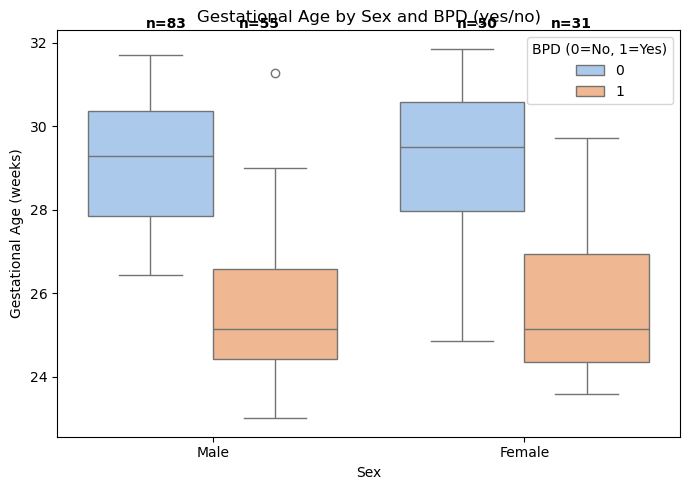

In [13]:
# Make group for plotting
df_plot = df_full.drop_duplicates("Anon.Patient_ID")[["sex_str", "BPD_yn", "GA_wd"]].dropna()

plt.figure(figsize=(7, 5))
sns.boxplot(x="sex_str", y="GA_wd", hue="BPD_yn", data=df_plot, palette="pastel")
# Add n per group
grouped = df_plot.groupby(["sex_str", "BPD_yn"]).size().unstack()
for i, sex in enumerate(["Male", "Female"]):
    for j, bpd in enumerate([0, 1]):
        n = grouped.loc[sex, bpd] if (sex in grouped.index and bpd in grouped.columns) else 0
        plt.text(i - 0.15 + j*0.3, df_plot["GA_wd"].max() + 0.5, f"n={n}", ha='center', fontweight='bold')
plt.title("Gestational Age by Sex and BPD (yes/no)")
plt.ylabel("Gestational Age (weeks)")
plt.xlabel("Sex")
plt.legend(title="BPD (0=No, 1=Yes)")
plt.tight_layout()
plt.show()


In [14]:
for sex in ["Male", "Female"]:
    ga_no = df_plot[(df_plot["sex_str"] == sex) & (df_plot["BPD_yn"] == 0)]["GA_wd"].dropna()
    ga_yes = df_plot[(df_plot["sex_str"] == sex) & (df_plot["BPD_yn"] == 1)]["GA_wd"].dropna()
    stat, p = mannwhitneyu(ga_no, ga_yes, alternative='two-sided')
    print(f"{sex}: Mann-Whitney U = {stat:.2f}, p = {p:.4f}")
    if p < 0.05:
        print(f"Significant difference in gestational age by BPD_yn for {sex}.")
    else:
        print(f"No significant difference in gestational age by BPD_yn for {sex}.")


Male: Mann-Whitney U = 4247.00, p = 0.0000
Significant difference in gestational age by BPD_yn for Male.
Female: Mann-Whitney U = 1395.00, p = 0.0000
Significant difference in gestational age by BPD_yn for Female.
